### import package

import package yang akan digunakan untuk notebook ini

In [ ]:
import numpy as np
import pandas as pd

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
import matplotlib.pyplot as plt

### import data dari google drive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
#@title 
file_path = "/content/gdrive/MyDrive/dts_project/dataset/time_series_dataset.csv" #@param {type:'string'}
print(f"Used File Path: {file_path}")

Used File Path: /content/gdrive/MyDrive/dts_project/dataset/time_series_dataset.csv


In [ ]:
query_data = pd.read_csv(file_path, encoding = 'windows-1252')
query_data

,rn,Order_Date,profit
0,1,2014-01-03,5.5512
1,2,2014-01-04,4.2717
2,3,2014-01-05,4.8840
3,4,2014-01-06,1358.0524
4,5,2014-01-09,10.9180
...,...,...,...
1201,1202,2017-12-26,63.7302
1202,1203,2017-12-27,3.6432
1203,1204,2017-12-28,322.4556
1204,1205,2017-12-29,688.7102


### import data dari bigquery

In [ ]:
from google.colab import auth
auth.authenticate_user()
print('Authenticated')

pada proses import data, dilakukan filter data dengan mengambil Profit > 0 (per Order_ID)

In [ ]:
%%bigquery --project golden-resolver-357006 query_data
WITH time_series AS (
  SELECT
    s.Order_Date,
    SUM(s.Profit) profit
  FROM
    `uprak.super_store_mat` s
  WHERE 
    s.Profit > 0
  GROUP BY
    1
  ORDER BY
    1 ASC)
SELECT
  ROW_NUMBER() OVER() rn,
  ts.*
FROM
  time_series ts
ORDER BY
  1 ASC

In [ ]:
# query_data

### pre-processing data

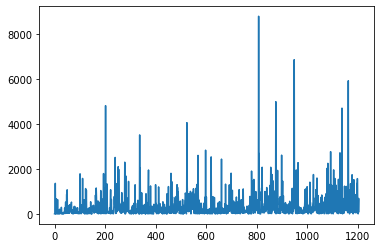

In [ ]:
query_data['profit'].plot.line()

In [ ]:
# merubah data menjadi bentuk float

data = query_data['profit'].astype(float)

input backdate yang ingin dijadikan acuan untuk forcast (days)

In [ ]:
#@title 
backdate =  60#@param {type:'number'}
print(f"Used Backdate: {backdate}")

Used Backdate: 60


input periode forcast (days)

In [ ]:
#@title 
forcast_period = 30 #@param {type:'number'}
print(f"Do a forcast: {forcast_period}")
forcast_period=forcast_period

Do a forcast: 30


In [ ]:
# membagi data menjadi 2, untuk train & untuk test/validator (forcast)
df_train=data[:len(data)-forcast_period]
df_test=data[len(data)-forcast_period:]

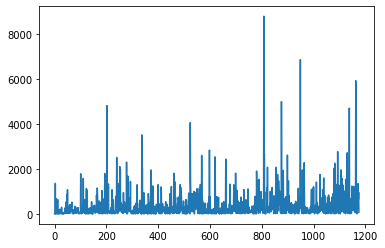

In [ ]:
plot_train = df_train
plot_train.plot.line()

plot data diatas merupakan data yang akan dijadikan sebagai bahan training

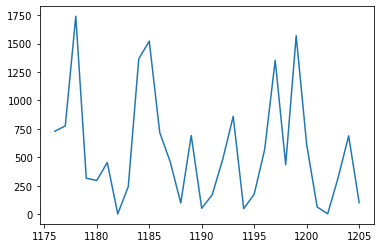

In [ ]:
plot_test = df_test
plot_test.plot.line()

plot data diatas merupakan data yang akan dijadikan sebagai validator forcast

In [ ]:
# merubah data manjadi bentuk dataframe
df_train=pd.DataFrame(df_train)
df_test=pd.DataFrame(df_test)

df_test = df_test.reset_index(drop=True)

In [ ]:
# melakukan scaling data, agar sebarannya menjadi seragam di range 0 hingga 1
sc = MinMaxScaler(feature_range = (0, 1))
train_scaled = sc.fit_transform(df_train)

mencacah data menjadi n-backdate<br>
misal n-backdate=60<br>
array[0] = data_train[0], data_train[1], data_train[2], ..., data_train[59]<br>
array[1] = data_train[1], data_train[2], data_train[3], ..., data_train[60]<br>
array[2] = data_train[2], data_train[3], data_train[4], ..., data_train[61]<br>

In [ ]:
X_train = []
y_train = []
for i in range(backdate, len(train_scaled)):
    X_train.append(train_scaled[i-backdate:i, 0])
    y_train.append(train_scaled[i, 0])
X_train, y_train = np.array(X_train), np.array(y_train)

# melakukan reshape array, 2 dimensonal array menjadi 3 dimensional array
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))

untuk melakukan forcast, kita juga butuh n-data backdate dan digabung dengan m-data_train<br>
agar bisa dicacah menjadi bentuk<br>

misal n-backdate=60 dan m-forcast=30 <br>
array[0] = data_train[-1], data_train[-2], data_train[-3], ..., data_train[-60]<br>
array[1] = data_train[-2], data_train[-3], ..., data_train[-60], data_forcast[1]<br>
array[2] = data_train[-3], ..., data_train[-60], data_forcast[1], data_forcast[2]

In [ ]:
dataset_total = pd.concat((df_train, df_test), axis = 0) #menggabung data_train dengan data_forcast, agar bisa dicacah
inputs = dataset_total[len(dataset_total) - len(df_test) - backdate:].values # mengambil n-backdate, dan ditambah dengan m-forcast_date

In [ ]:
dataset_total = pd.concat((df_train, df_test), axis = 0) #menggabung data_train dengan data_forcast, agar bisa dicacah
inputs = dataset_total[len(dataset_total) - len(df_test) - backdate:].values # mengambil n-backdate, dan ditambah dengan m-forcast_date
# inputs = inputs.reshape(-1,1)
inputs = sc.transform(inputs) #proses scaling agar sebaran data seragam di range 0 hingga 1

# mencacah data per-n-backdate
X_test = []
for i in range(backdate, backdate+len(df_test)):
    X_test.append(inputs[i-backdate:i, 0])
X_test = np.array(X_test)

# melakukan reshape array, 2 dimensonal array menjadi 3 dimensional array
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:451: UserWarning: X does not have valid feature names, but MinMaxScaler was fitted with feature names
  "X does not have valid feature names, but"


### membangun model neural network

input ensemble (perulangan) model, n-kali

In [ ]:
#@title 
ensemble =  1#@param {type:'number'}
print(f"Ensemble: {ensemble} Times")

Ensemble: 1 Times


ensembel dilakukan untuk perulangan model, untuk mengetahui rata-rata dari forcast yang telah dilakukan pada masing-masing ensemble.<br>
sehingga rata-rata dari model tersebut dapat merepresentasikan suatu titik dari semua percobaan (ensemble) yang telah dilakukan

In [ ]:
loss=[]
result=[]

for i in range(ensemble):
  print("Ensemble ke-",i+1)

  model = Sequential()
  model.add(LSTM(units = 32, input_shape = (X_train.shape[1],1)))
  model.add(Dense(units = 1))

  model.compile(optimizer = 'adam', loss = 'mean_squared_error')
  
  history = model.fit(X_train, y_train, epochs = 60, batch_size = 1, verbose=2)
  
  loss.append(history.history['loss'][-1])
  
  print("Loss terakhir Ensemble ke",i+1," : ",history.history['loss'][-1])
  
  forcasted = model.predict(X_test)
  forcasted = sc.inverse_transform(forcasted) # dilakukan inverse_transform, agar data yang discaling bisa kembali ke bentuk awal
  result.append(forcasted)

Ensemble ke- 1
Epoch 1/60
1116/1116 - 10s - loss: 0.0053 - 10s/epoch - 9ms/step
Epoch 2/60
1116/1116 - 4s - loss: 0.0053 - 4s/epoch - 4ms/step
Epoch 3/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 4/60
1116/1116 - 4s - loss: 0.0053 - 4s/epoch - 4ms/step
Epoch 5/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 6/60
1116/1116 - 4s - loss: 0.0053 - 4s/epoch - 4ms/step
Epoch 7/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 8/60
1116/1116 - 5s - loss: 0.0052 - 5s/epoch - 4ms/step
Epoch 9/60
1116/1116 - 4s - loss: 0.0053 - 4s/epoch - 4ms/step
Epoch 10/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 11/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 12/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 13/60
1116/1116 - 4s - loss: 0.0053 - 4s/epoch - 4ms/step
Epoch 14/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 15/60
1116/1116 - 4s - loss: 0.0052 - 4s/epoch - 4ms/step
Epoch 16/60
1116/1116 - 5s - los

menggunakan model yang cenderung sederhana,<br>
karena jika model terlalu kompleks (banyak layer & nodes) hasilnya kurang memuaskan,<br>
menghasilkan forcast garis lurus (stasioner), hal tersebut yang disebabkan oleh persebaran data yang cenderung stasioner dan dataset yang cenderung sedikit untuk pengolahan data menggunakan neural-network

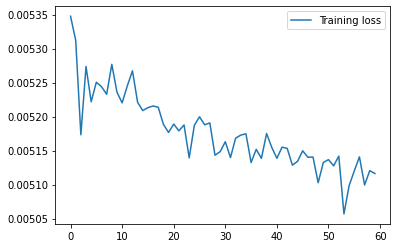

In [ ]:
plt.plot(history.history['loss'], label='Training loss')
plt.legend()

### hasil forcast

In [ ]:
np_result= np.array(result)
final_forcast = np.average(np_result, axis=0)

In [ ]:
final_forcast=pd.DataFrame(final_forcast)

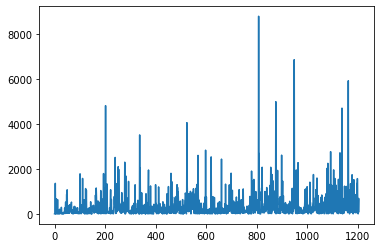

In [ ]:
data.plot.line()

dari plot data diatas, terlihat bahwa trend datanya cenderung stasioner di persekitaran 0 hingga 1000

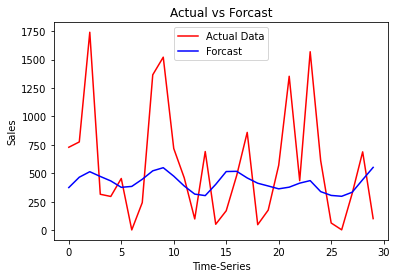

In [ ]:
plt.plot(df_test, color = 'red', label = 'Actual Data')
plt.plot(final_forcast, color = 'blue', label = 'Forcast')
plt.title('Actual vs Forcast')
plt.xlabel('Time-Series')
plt.ylabel('Sales')
plt.legend()
plt.show()


karena data historicalnya memiliki trend dipersekitaran 0 hingga 1000,<br>
maka data forcast juga cenderung stasioner di angka yang mirip

### daftar pustaka <br>
1. https://towardsdatascience.com/lstm-for-google-stock-price-prediction-e35f5cc84165 <br>
2. https://www.kaggle.com/code/ptheru/google-stock-price-prediction-rnn <br>
4. https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/